# PROBLEM FORMULATION

- Understand which factors influence churn the most
- Identify individuals with high probability of churning
- Build a churn prediction model (model used : xgboost) 

# 1.Loading the raw data  

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [10]:
raw_data = pd.read_csv('./Bank_churn_data.csv')
raw_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


# 2.Data Preprocessing

## 2.1 Understanding the data

In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


### Target Column : Exited

- 0 stands for the customer did not churn or exited
- 1 stands for that the customer churned or exited

In [12]:
# Investigating all the elements within each feature

for col in raw_data:
    unique_vals = raw_data[col].dropna().unique()
    n_vals = len(unique_vals)
    if n_vals <= 12:
        print('The number of values for feature {}:{} -- {}'.format(col,n_vals,unique_vals))
    else:
        print('The number of values for feature {}:{}'.format(col,n_vals))

The number of values for feature RowNumber:10000
The number of values for feature CustomerId:10000
The number of values for feature Surname:2932
The number of values for feature CreditScore:460
The number of values for feature Geography:3 -- ['France' 'Spain' 'Germany']
The number of values for feature Gender:2 -- ['Female' 'Male']
The number of values for feature Age:73
The number of values for feature Tenure:11 -- [ 2  1  8  7  4  6  3 10  5  9  0]
The number of values for feature Balance:6382
The number of values for feature NumOfProducts:4 -- [1 3 2 4]
The number of values for feature HasCrCard:2 -- [1. 0.]
The number of values for feature IsActiveMember:2 -- [1. 0.]
The number of values for feature EstimatedSalary:9999
The number of values for feature Exited:2 -- [1 0]


In [13]:
# Checking for null values
raw_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [14]:
# The rows with null values can be dropped since they are insignificant in number and can be ignored
raw_data.dropna(inplace = True)
raw_data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 2.2 Visualizing the data

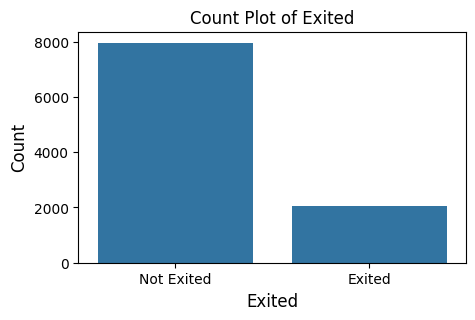

In [15]:
# Count plot of the target value : Checking if the dataset is balanced
plt.figure(figsize = (5,3))
sns.countplot(data=raw_data,x="Exited")
plt.title("Count Plot of Exited",fontsize = 12)
plt.xlabel("Exited",fontsize = 12)
plt.ylabel("Count",fontsize = 12)
plt.xticks([0,1],labels=["Not Exited", "Exited"])
plt.show()

### Conclusion 
From the count plot we can infer that the dataset is imbalanced i.e, there is more rows or information about customers that exited or churned but very less about who did churn

Will try oversampling during training the data

### Drawing insights from dataset

In [16]:
# Geography-wise Churn Rate
geo_churn = raw_data.groupby("Geography")["Exited"].mean().reset_index()
geo_churn.columns = ["Geography", "Churn Rate"]

# Age-wise Churn Rate
# Create age bins
raw_data["Age Group"] = pd.cut(raw_data["Age"], bins=[18, 25, 35, 50, 100], labels=["18-25", "26-35", "36-50", "50+"])
age_churn = raw_data.groupby("Age Group")["Exited"].mean().reset_index()
age_churn.columns = ["Age Group", "Churn Rate"]

# Balance vs. Churn (average balance)
balance_churn = raw_data.groupby("Exited")["Balance"].mean().reset_index()
balance_churn["Churn Status"] = balance_churn["Exited"].replace({0: "Retained", 1: "Churned"})
balance_churn = balance_churn[["Churn Status", "Balance"]]

# Tenure Impact on Churn
tenure_churn = raw_data.groupby("Tenure")["Exited"].mean().reset_index()
tenure_churn.columns = ["Tenure", "Churn Rate"]

# Credit Score vs. Churn
credit_churn = raw_data.groupby("Exited")["CreditScore"].mean().reset_index()
credit_churn["Churn Status"] = credit_churn["Exited"].replace({0: "Retained", 1: "Churned"})
credit_churn = credit_churn[["Churn Status", "CreditScore"]]

# Save all insights to an Excel file
with pd.ExcelWriter("churn_insights.xlsx") as writer:
    geo_churn.to_excel(writer, sheet_name="Geo Churn", index=False)
    age_churn.to_excel(writer, sheet_name="Age Churn", index=False)
    balance_churn.to_excel(writer, sheet_name="Balance vs Churn", index=False)
    tenure_churn.to_excel(writer, sheet_name="Tenure Churn", index=False)
    credit_churn.to_excel(writer, sheet_name="Credit vs Churn", index=False)

print("Real data insights saved to churn_insights.xlsx!")

Real data insights saved to churn_insights.xlsx!


C:\Users\profe\AppData\Local\Temp\ipykernel_66876\5390988.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_churn = raw_data.groupby("Age Group")["Exited"].mean().reset_index()


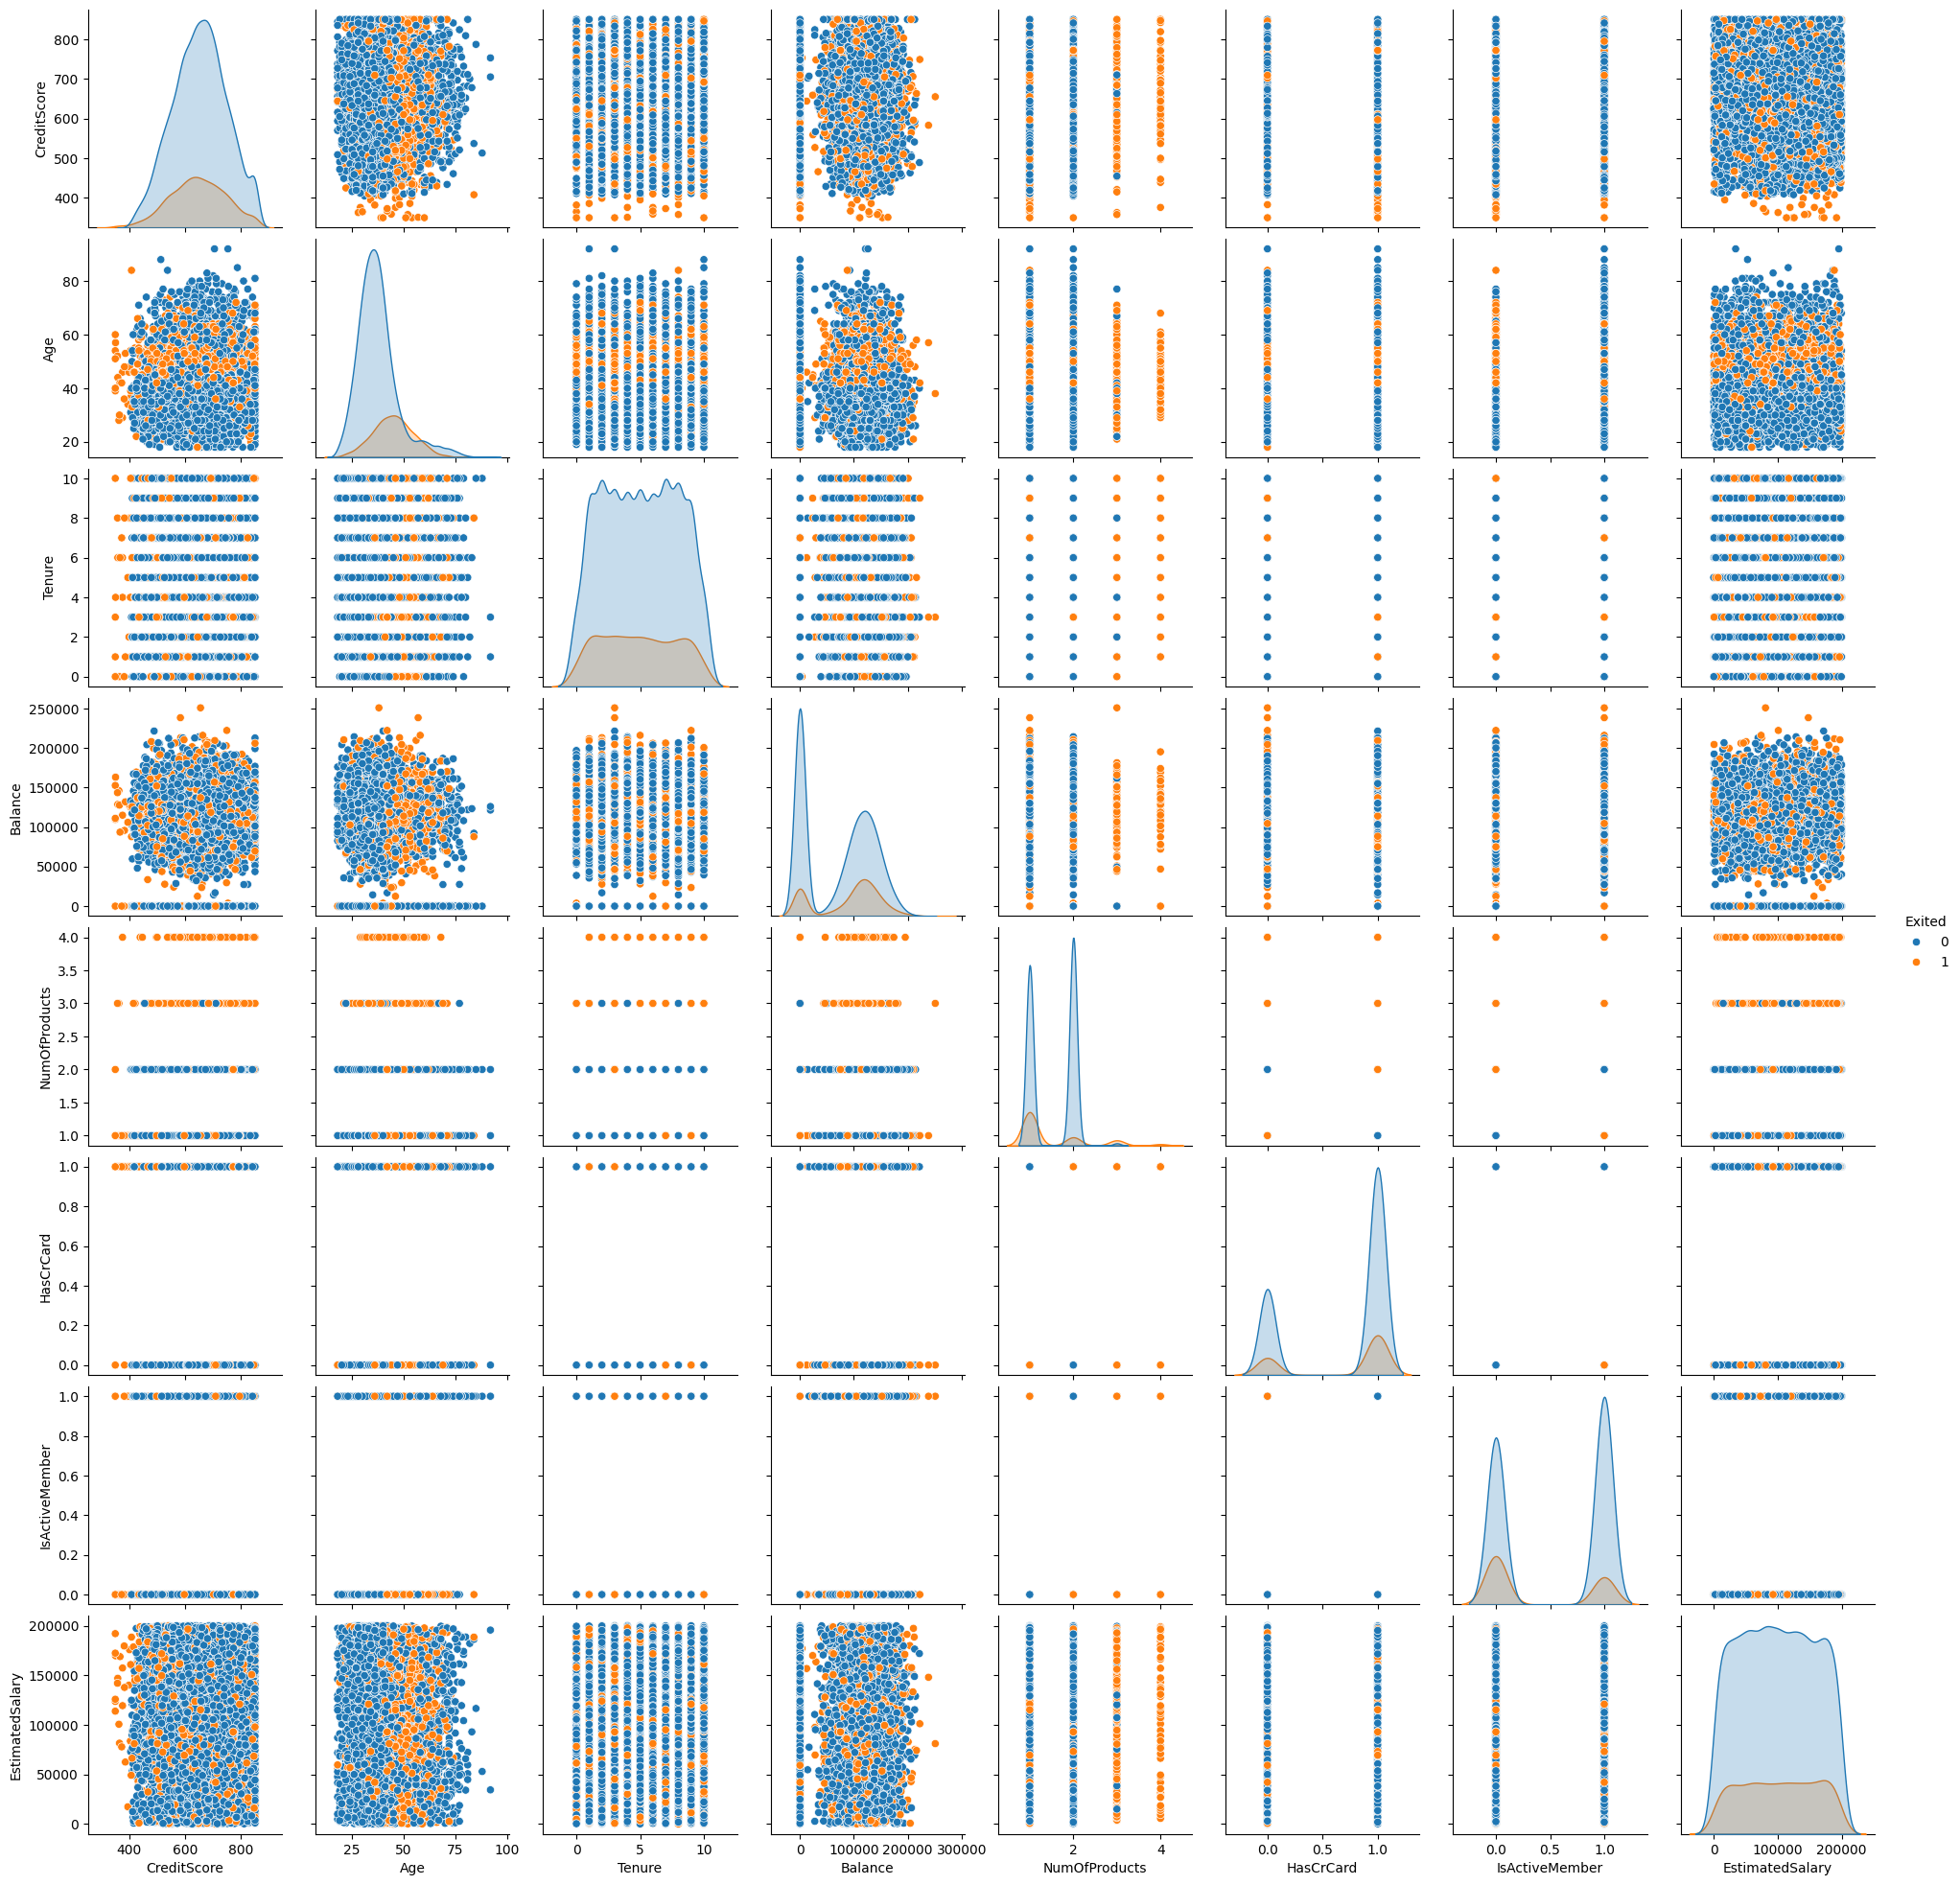

In [17]:
raw_data_relevant_cols = raw_data[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','Exited']]
# visualizing
g = sns.pairplot(raw_data_relevant_cols,hue = 'Exited')
plt.show()

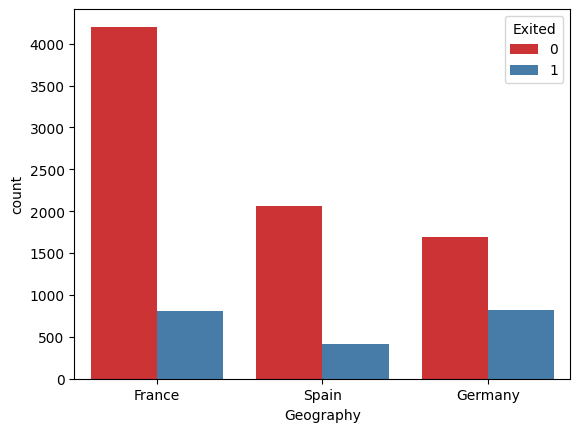

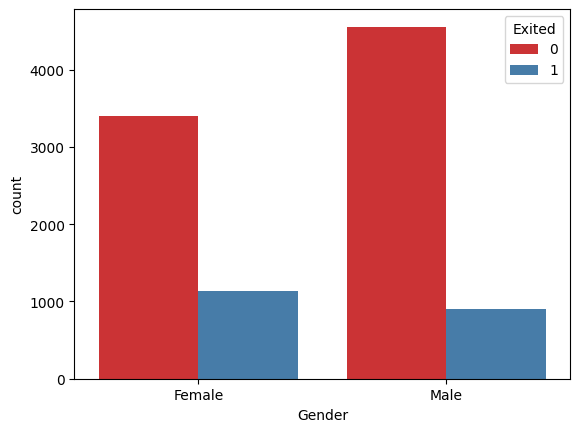

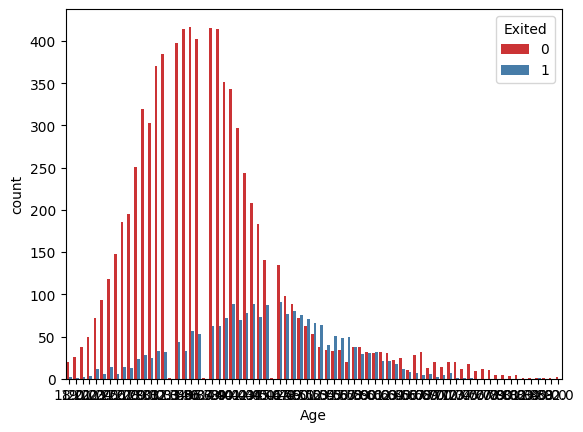

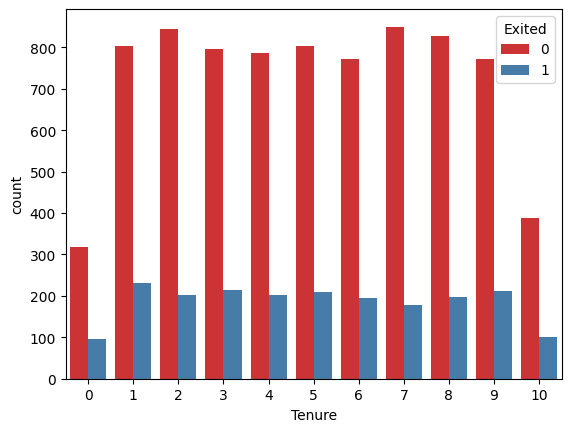

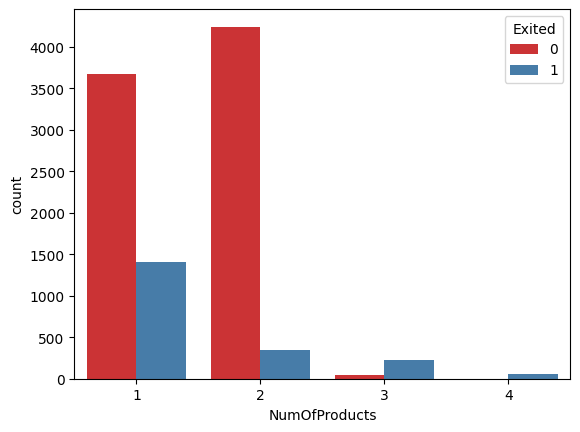

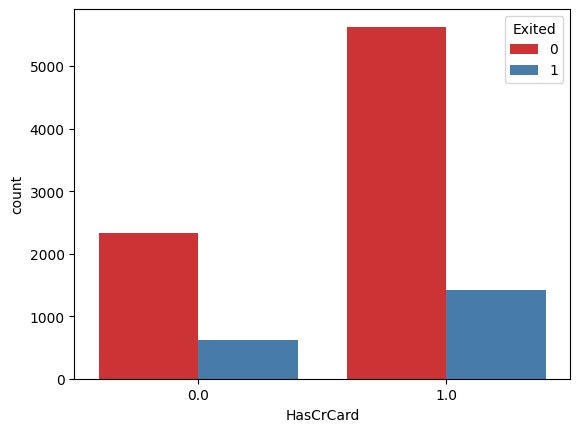

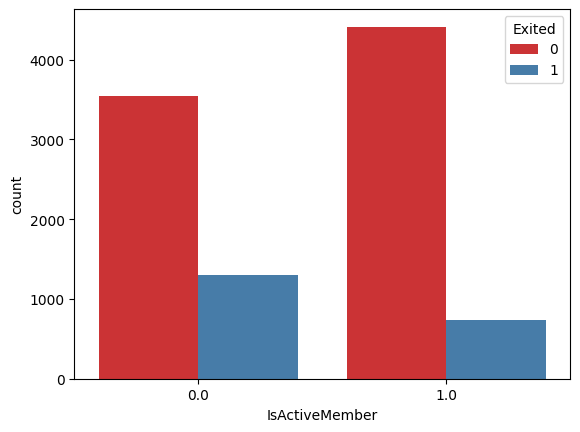

In [18]:
#Investigating categorical features
features = raw_data[['Geography','Gender','Age','Tenure','NumOfProducts','HasCrCard','IsActiveMember']]

for f in features:
    plt.figure()
    cp = sns.countplot(x = f,data=raw_data,hue = 'Exited',palette='Set1')

The median is:  652.0


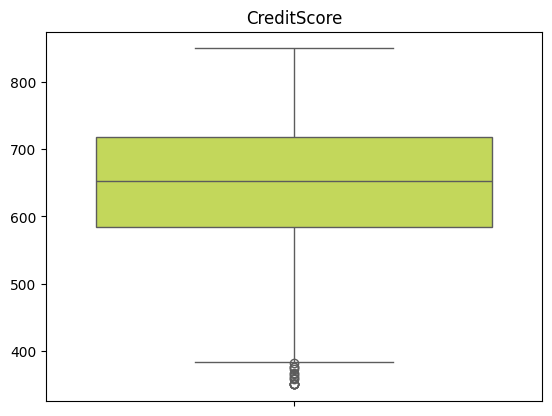

The median is:  37.0


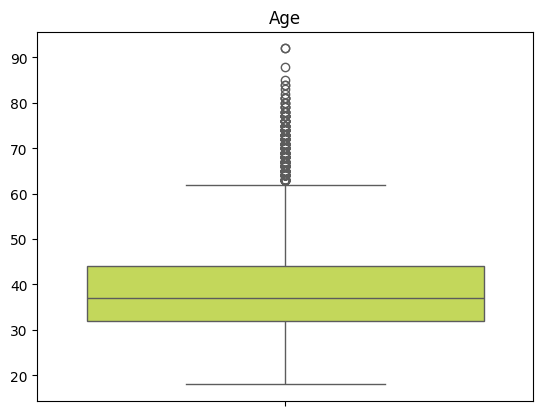

The median is:  5.0


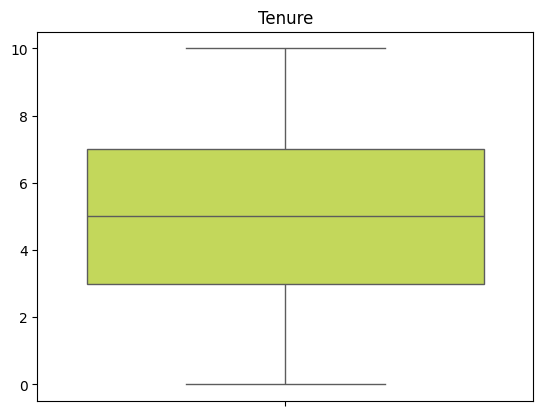

The median is:  97173.29000000001


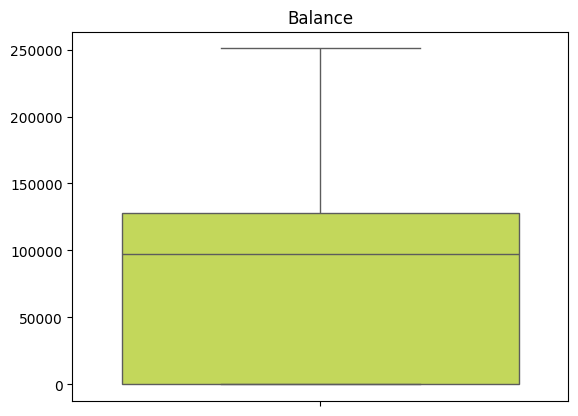

The median is:  1.0


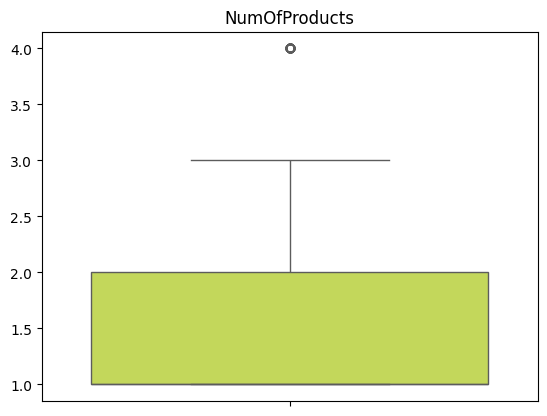

The median is:  1.0


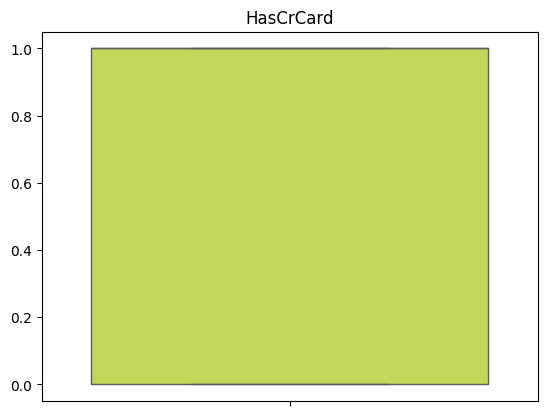

The median is:  1.0


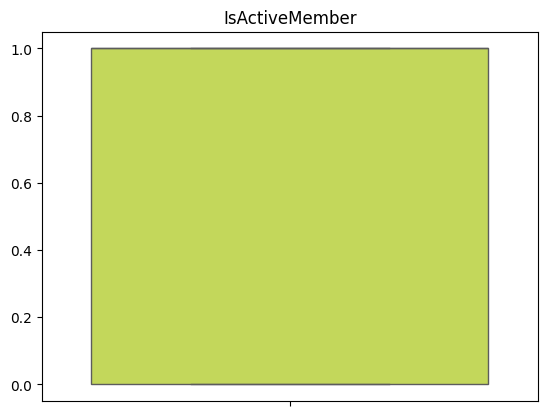

The median is:  100218.20999999999


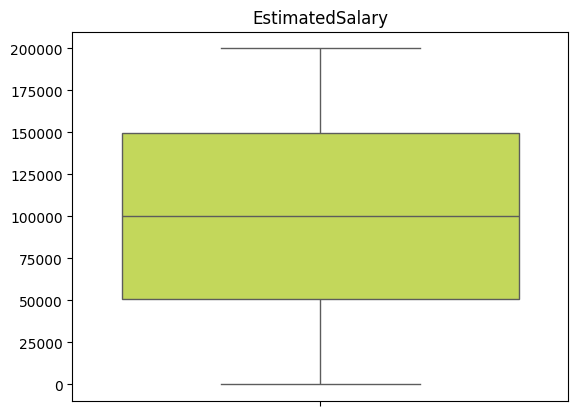

The median is:  0.0


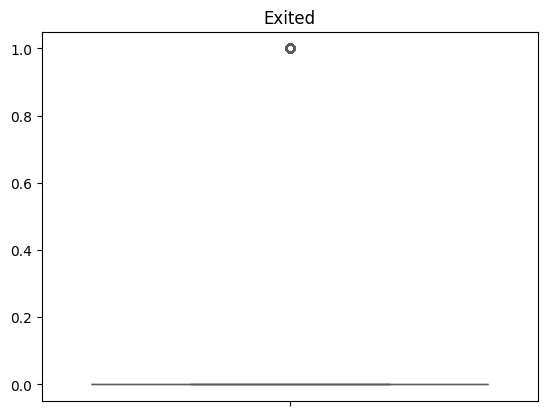

In [19]:
#Investigating numerical features
numerics = ['int16','int32','int64','float16','float32','float64']
numeric_cols = raw_data_relevant_cols.select_dtypes(numerics).columns
numeric_cols

for col in numeric_cols:
    x = raw_data[col].values
    bp = sns.boxplot(x,color='#D1EC46')
    print('The median is: ',raw_data[col].median())
    plt.title(col)
    plt.show()

## 2.3 Preparing the final dataframe

In [20]:
# Converting categorical variables into numerical types
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# raw_data_relevant_cols.info()
cols_to_encode = ['HasCrCard','IsActiveMember','Geography','Gender']
# for col in cols_to_encode:
#     raw_data_relevant_cols[col] = encoder.fit_transform(raw_data_relevant_cols[col])
raw_data_relevant_cols = pd.get_dummies(raw_data_relevant_cols, columns=cols_to_encode)

In [21]:
final_raw_data = raw_data_relevant_cols
final_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42.0,2,0.00,1,101348.88,1,False,True,False,True,True,False,False,True,False
1,608,41.0,1,83807.86,1,112542.58,0,True,False,False,True,False,False,True,True,False
2,502,42.0,8,159660.80,3,113931.57,1,False,True,True,False,True,False,False,True,False
3,699,39.0,1,0.00,2,93826.63,0,True,False,True,False,True,False,False,True,False
5,645,44.0,8,113755.78,2,149756.71,1,False,True,True,False,False,False,True,False,True


In [22]:
# Scaling 
features_to_scale = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
scaler = MinMaxScaler()
final_raw_data[features_to_scale] = scaler.fit_transform(raw_data[features_to_scale])

In [23]:
final_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.538,0.324324,0.2,0.000000,0.000000,0.506735,1,False,True,False,True,True,False,False,True,False
1,0.516,0.310811,0.1,0.334031,0.000000,0.562709,0,True,False,False,True,False,False,True,True,False
2,0.304,0.324324,0.8,0.636357,0.666667,0.569654,1,False,True,True,False,True,False,False,True,False
3,0.698,0.283784,0.1,0.000000,0.333333,0.469120,0,True,False,True,False,True,False,False,True,False
5,0.590,0.351351,0.8,0.453394,0.333333,0.748797,1,False,True,True,False,False,False,True,False,True


In [24]:
# !pip install xgboost

# Run XGBoost

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay

C:\Users\profe\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:32:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training accuracy : 0.96
Test accuracy : 0.85


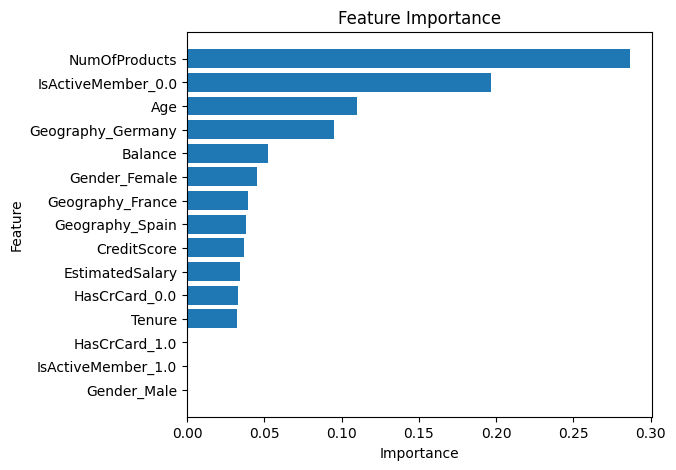


Feature Importance:


,Feature,Importance
4,NumOfProducts,0.286490
8,IsActiveMember_0.0,0.196729
1,Age,0.110186
11,Geography_Germany,0.095154
3,Balance,0.052161
13,Gender_Female,0.045269
10,Geography_France,0.039586
12,Geography_Spain,0.037958
0,CreditScore,0.036880
5,EstimatedSalary,0.034369


In [26]:
# features (X) and Target (y)
X = final_raw_data.drop(columns=['Exited'])
y = final_raw_data["Exited"]

#Splitting the dataset into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#Training the model
model = XGBClassifier(use_label_encoder=False,eval_metrics='logloss',random_state=42)
model.fit(X_train,y_train)

#Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Training and testing accuracy
train_accuracy = accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)
print(f"Training accuracy : {train_accuracy:.2f}")
print(f"Test accuracy : {test_accuracy:.2f}")

#Feature Importance
feature_importance = pd.DataFrame({
    "Feature":X_train.columns,
    "Importance":model.feature_importances_
}).sort_values(by="Importance",ascending=False)

#Plotting feature importance
plt.figure(figsize=(6,5))
plt.barh(feature_importance["Feature"],feature_importance["Importance"],align="center")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Displaying feature importance
print("\nFeature Importance:")
feature_importance

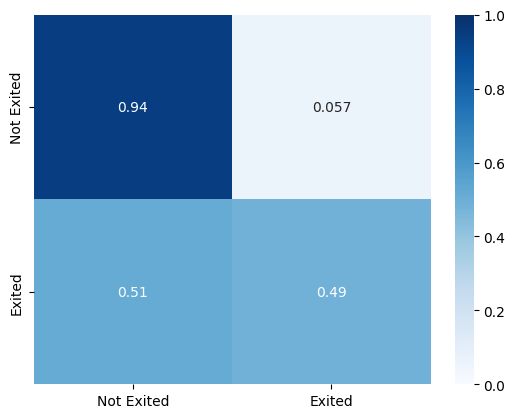

In [27]:
def plot_confusion_matrix(cm,classes=None,title='Confusion Matrix'):
    sns.heatmap(cm,xticklabels=classes,yticklabels=classes,vmin=0,vmax=1,annot=True,cmap='Blues')

cm = confusion_matrix(y_test,y_test_pred,normalize='true')
plot_confusion_matrix(cm,['Not Exited','Exited'])

C:\Users\profe\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:32:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training accuracy : 0.96
Test accuracy : 0.85


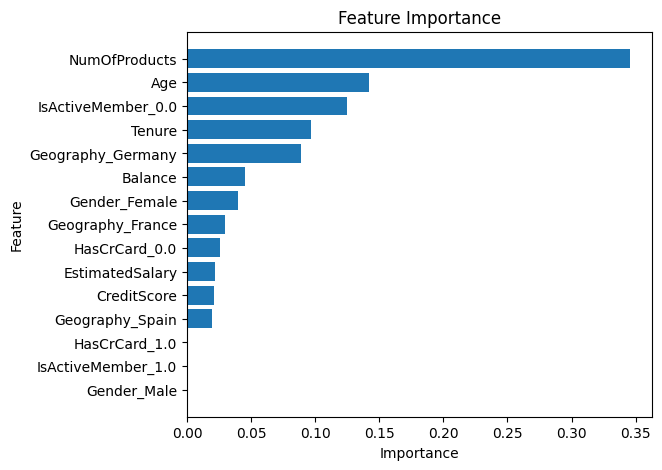


Feature Importance:


,Feature,Importance
4,NumOfProducts,0.345521
1,Age,0.141649
8,IsActiveMember_0.0,0.124489
2,Tenure,0.096810
11,Geography_Germany,0.089183
3,Balance,0.045273
13,Gender_Female,0.039508
10,Geography_France,0.029549
6,HasCrCard_0.0,0.025526
5,EstimatedSalary,0.021617


In [28]:
# using SMOTE to balance the data

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

smote = SMOTE(random_state = 42)
X_train_resampled,y_train_resampled = smote.fit_resample(X_train,y_train)

# Reruning XGBoost using smote
model = XGBClassifier(use_label_encoder=False,eval_metrics='logloss',random_state=42)
model.fit(X_train_resampled,y_train_resampled)

#Predictions
y_train_pred = model.predict(X_train_resampled)
y_test_pred = model.predict(X_test)

#Training and testing accuracy
train_accuracy = accuracy_score(y_train_resampled,y_train_pred)
test_accuracy = accuracy_score(y_test,y_test_pred)
print(f"Training accuracy : {train_accuracy:.2f}")
print(f"Test accuracy : {test_accuracy:.2f}")

#Feature Importance
feature_importance = pd.DataFrame({
    "Feature":X_train.columns,
    "Importance":model.feature_importances_
}).sort_values(by="Importance",ascending=False)

#Plotting feature importance
plt.figure(figsize=(6,5))
plt.barh(feature_importance["Feature"],feature_importance["Importance"],align="center")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Displaying feature importance
print("\nFeature Importance:")
feature_importance

In [29]:
# !pip install imblearn

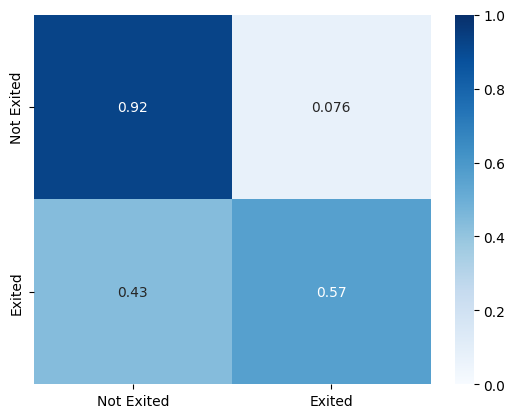

In [30]:
cm = confusion_matrix(y_test,y_test_pred,normalize='true')
plot_confusion_matrix(cm,['Not Exited','Exited'])

In [31]:
# 4. Hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [3, 5, 7, 10],      # Maximum depth of a tree
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    "subsample": [0.6, 0.8, 1.0],    # Fraction of samples to grow trees
    "colsample_bytree": [0.6, 0.8, 1.0],  # Fraction of features for tree building
    "gamma": [0, 1, 5],              # Minimum loss reduction for split
    "reg_lambda": [1, 10, 50],       # L2 regularization term
}

# Initialize the base XGBoost classifier
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)

# Apply RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring="f1",
    cv=3,  # 3-fold cross-validation
    random_state=42,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and model
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Re-train the model with the best hyperparameters
best_model = random_search.best_estimator_
best_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred = best_model.predict(X_train_resampled)
y_test_pred = best_model.predict(X_test)
all_df_predict = best_model.predict(X)
all_df_predict_prob = best_model.predict_proba(X)

# Training and Testing Accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
feature_importance

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\profe\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:32:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'subsample': 1.0, 'reg_lambda': 10, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}


C:\Users\profe\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:32:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Accuracy: 0.95
Testing Accuracy: 0.85


,Feature,Importance
4,NumOfProducts,0.434921
1,Age,0.115434
8,IsActiveMember_0.0,0.087572
11,Geography_Germany,0.064597
9,IsActiveMember_1.0,0.064569
2,Tenure,0.053610
3,Balance,0.032792
14,Gender_Male,0.029340
13,Gender_Female,0.025884
12,Geography_Spain,0.019146


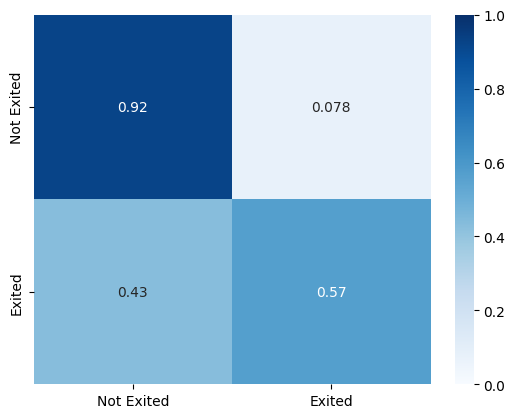

In [32]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
plot_confusion_matrix(cm, classes=["Not Exited", "Exited"])

# 5. Storing Models and Results

In [33]:
# Adding the predictions back to the original dataset
raw_data['Exited Predcition'] = all_df_predict
raw_data['Exited Prediction Probability'] = all_df_predict_prob[:,1]

#Exporting all the data with predictions
raw_data.to_excel("bank_churn_data.xlsx")

In [34]:
# !pip install openpyxl

In [35]:
# Storing the feature importances
feature_importance['Feature Importance Score'] = feature_importance['Importance'].round(4)
feature_importance.to_excel("feature_importance.xlsx")

In [36]:
# Save the best model to a file
import pickle

with open('best_model.pkl','wb') as file:
    pickle.dump(best_model,file)

print("Model saved successfully!")

# Saving the scaler
with open('scaler.pkl','wb') as file:
    pickle.dump(scaler,file)

Model saved successfully!


# 6. Streamlit App

on cmd : 
###### streamlit run Churn_prediction_app.py